In [1]:
using MATLAB
using BSON
using Random

In [2]:
include("../../src/NNSurrogate.jl")
include("../../src/NNJuMP.jl")
include("../../src/NNGogeta.jl")
include("../../src/MCDropout.jl")

generate_resample_configs_mc (generic function with 1 method)

# Blade max-temperature simulation model 
6 input variables, 1 output

In [3]:
Random.seed!(101)

TaskLocalRNG()

Use the simulator from [Thermal Stress Analysis of Jet Engine Turbine Blade](https://se.mathworks.com/help/pde/ug/thermal-stress-analysis-of-jet-engine-turbine-blade.html)

In [4]:
# add the path of the MATLAB code
mat"addpath('MaxTemp')"

# arguments: T_air, T_gas, h_air, h_gas_pressureside, h_gas_suctionside, h_gas_tip
blade_max_temp(x::NTuple{6, Float64}) = mat"computeMaxTemp($(x[1]), $(x[2]), $(x[3]), $(x[4]), $(x[5]), $(x[6]))"

blade_max_temp (generic function with 1 method)

# Initial training

One can directly generate data using blade_max_temp which takes much longer.  
`data_temp = generate_data(blade_max_temp, sampling_config_init, SobolSample(), 0.8)`

Here, we generate data using MATLAB and save it to a CSV file `combined_data.csv`

In [5]:
L_bounds_init = [120, 900, 20, 40, 30, 10]
U_bounds_init = [180, 1200, 40, 60, 50, 30]
sampling_config_init = Sampling_Config(1000, L_bounds_init, U_bounds_init)

root = dirname(@__FILE__)
csv_file_path = joinpath(root, "combined_data.csv")
data_temp = load_data(csv_file_path, 0.8, 6, 1)

NN_Data(Float32[125.56641 161.74805 … 149.41086 166.16867; 948.33984 1156.2012 … 1049.8009 1003.5118; … ; 38.61328 45.88867 … 40.201263 34.927826; 28.066406 28.291016 … 16.119537 16.236725], Float32[764.0843 997.7488 … 910.9875 851.6478], Float32[124.215546 163.1218 … 143.83438 168.85391; 1157.0275 1084.3712 … 1195.5299 1011.8385; … ; 41.0997 41.88095 … 35.65811 49.70108; 23.3461 26.62735 … 12.512665 16.672821], Float32[972.9058 905.74646 … 969.33765 875.5493])

In [7]:
# train the surrogate model
config_temp = NN_Config([6,50,50,1], [relu, relu, identity], false, 0.0, 0.0, Flux.Optimise.Optimiser(Adam(0.1, (0.9, 0.999)), ExpDecay(1.0)), 1, 800, 1000, 0)
train_time = @elapsed result_temp = NN_train(data_temp, config_temp)
NN_results(config_temp, result_temp)
model_init = result_temp.model

Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Layers: [6, 50, 50, 1], Epochs: 1000, Lambda: 0.0, Dropout rate: 0.0
    Train Error[MSE, RRMSE, MAPE]: Float32[25.936739, 0.00020277037, 0.004667837]
    Test Error [MSE, RRMSE, MAPE]: Float32[24.075108, 0.0003910476, 0.0045599495]


Chain(
  Dense(6 => 50),                       # 350 parameters
  NNlib.relu,
  Dropout(0.0, active=false),
  Dense(50 => 50),                      # 2_550 parameters
  NNlib.relu,
  Dense(50 => 1),                       # 51 parameters
  identity,
)                   # Total: 6 arrays, 2_951 parameters, 11.935 KiB.

In [8]:
BSON.@save joinpath(@__DIR__, "models/surrogate_init.bson") model_init
# BSON.@load joinpath(@__DIR__, "models/surrogate_init.bson") model_init

# Formulate MIP

In [9]:
MILP_bt = Model()
set_optimizer(MILP_bt, Gurobi.Optimizer)
set_silent(MILP_bt)
set_attribute(MILP_bt, "TimeLimit", 10)
build_time = @elapsed _, _, _, _ = NN_formulate!(MILP_bt, model_init, 
    sampling_config_init.ub, sampling_config_init.lb; 
    bound_tightening="fast", compress=true, silent=false)

Set parameter Username
Set parameter LicenseID to value 2603857
Academic license - for non-commercial use only - expires 2025-12-27
Starting compression...



LAYER 1
Removed 45/50 neurons

LAYER 2
Removed 40/50 neurons

LAYER 3
Creating JuMP model...

LAYER 1

LAYER 2

LAYER 3


5.2985871

In [10]:
@objective(MILP_bt, Min, MILP_bt[:x][3,1])

set_attribute(MILP_bt, "TimeLimit", 1800)
solving_time = @elapsed optimize!(MILP_bt)

0.1140394

In [11]:
x_star_init = [value.(MILP_bt[:x][0,i]) for i in 1:length(MILP_bt[:x][0,:])]
solution_evaluate(MILP_bt, blade_max_temp, 1e-3)

        MIP solution: [120.0, 900.0, 40.0, 40.0, 30.0, 10.0]
     Objective value: 686.1431816754031
True objective value: 675.1318404785549


(686.1431816754031, 675.1318404785549, [120.0, 900.0, 40.0, 40.0, 30.0, 10.0], [120.0, 900.0, 40.0, 40.0, 30.0, 10.0], 0.01630991242990853)

In [12]:
# store multiple solutions in the solution pool
num_solutions_init_bt = MOI.get(MILP_bt, MOI.ResultCount())
sol_pool_x_init_bt, _ = sol_pool(MILP_bt, num_solutions_init_bt)

Solution 1:
   x = [120.0, 900.0, 40.0, 40.0, 30.0, 10.0]
 obj = 686.1431816754031


(Any[[120.0, 900.0, 40.0, 40.0, 30.0, 10.0]], Any[686.1431816754031])

# Uncertainty estimate

In [13]:
# apply Monte Carlo Dropout to the surrogate model
config_temp_dp = NN_Config([6,50,50,1], [relu, relu, identity], false, 0.0, 0.1, Flux.Optimise.Optimiser(Adam(0.1, (0.9, 0.999)), ExpDecay(1.0)), 1, 800, 1000, 0)
train_time = @elapsed result_temp_dp = NN_train(data_temp, config_temp_dp)

pred, pred_dist, means, stds, x_top_std = predict_dist(data_temp, result_temp.model, 100, 10)

Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000


(Matrix{Float32}[[765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297]  …  [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297], [765.6054 991.83606 … 972.2242 876.85297]], [[765.6054077148438; 765.6054077148438; … ; 765.6054077148438; 765.6054077148438;;], [991.8360595703125; 991.8360595703

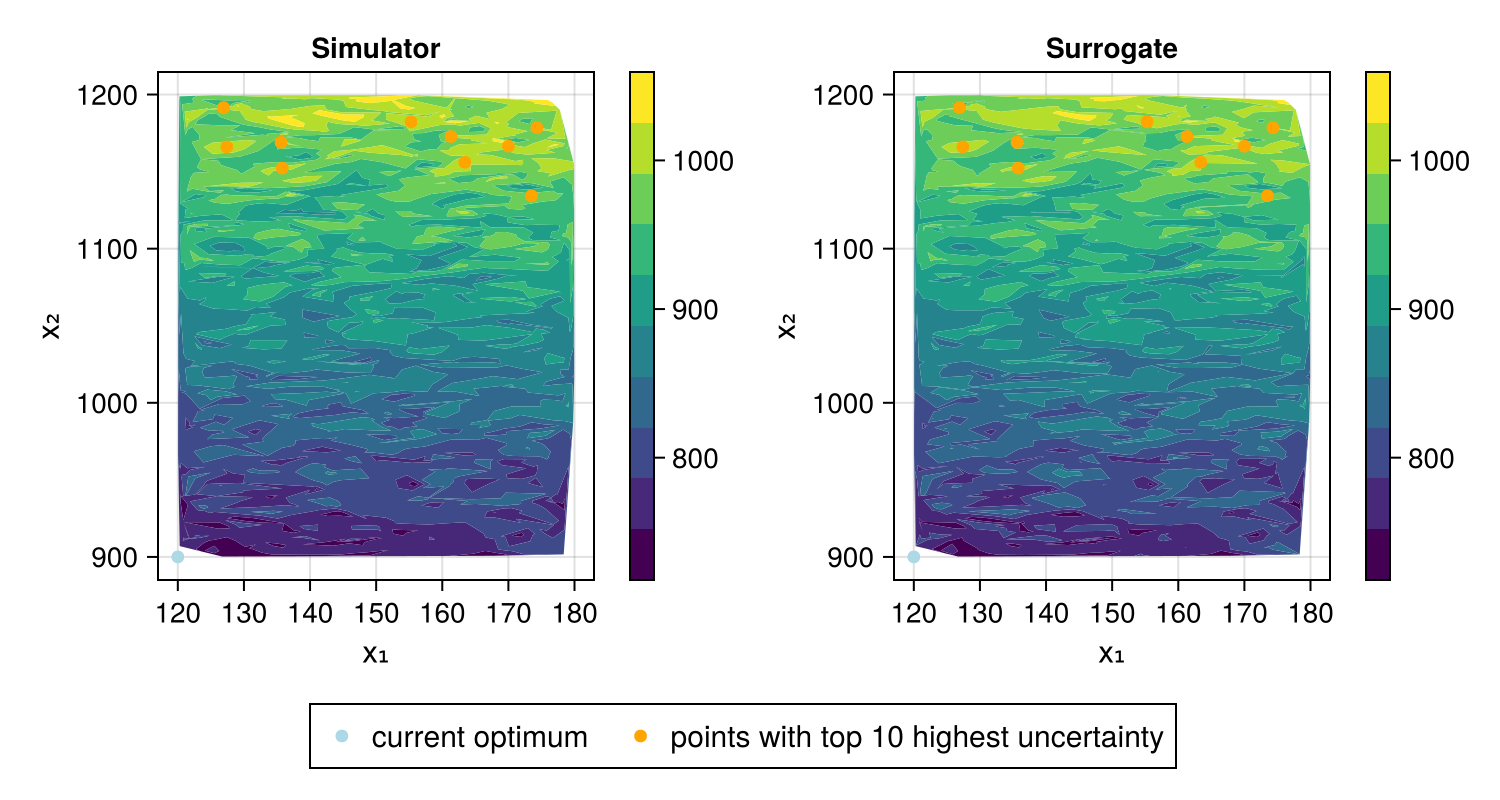

In [14]:
fig = plot_dual_contours(data_temp, model_init, x_star_init, "points with top 10 highest uncertainty", [col for col in eachcol(x_top_std)], [1,2], 1)

# Iterative refinement

## 1st iteration

In [15]:
# Resample densely around the points with the key points
sampling_configs_1st, sampling_config_1st = generate_resample_configs_mc(
    sampling_config_init, 
    [x_top_std x_star_init], 
    0.10, 
    0.3, 
    zeros(Float64, 6, 1), 
    ones(Float64, 6, 1))

(Sampling_Config[Sampling_Config(28, [124.4212646484375, 1151.0247802734375, 20.0, 50.1248779296875, 45.4849853515625, 28.9493408203125], [130.4212646484375, 1181.0247802734375, 21.9320068359375, 52.1248779296875, 47.4849853515625, 30.0]), Sampling_Config(28, [132.8001708984375, 1137.2552490234375, 23.6234130859375, 52.4881591796875, 47.9263916015625, 28.6173095703125], [138.8001708984375, 1167.2552490234375, 25.6234130859375, 54.4881591796875, 49.9263916015625, 30.0]), Sampling_Config(28, [132.60150146484375, 1154.013916015625, 26.64129638671875, 49.56304931640625, 45.44622802734375, 12.04962158203125], [138.60150146484375, 1184.013916015625, 28.64129638671875, 51.56304931640625, 47.44622802734375, 14.04962158203125]), Sampling_Config(28, [160.39874267578125, 1141.0408935546875, 24.12237548828125, 43.44427490234375, 46.45635986328125, 22.14544677734375], [166.39874267578125, 1171.0408935546875, 26.12237548828125, 45.44427490234375, 48.45635986328125, 24.14544677734375]), Sampling_Conf

In [16]:
data_temp_1st_new = generate_and_combine_data(blade_max_temp, sampling_configs_1st, SobolSample(), 0.8)
data_temp_1st = combine_datasets(data_temp, data_temp_1st_new)
data_temp_1st_filtered = filter_data_within_bounds(data_temp_1st, sampling_config_1st.lb, sampling_config_1st.ub)

Data generated for config: #1
Data generated for config: #2
Data generated for config: #3
Data generated for config: #4
Data generated for config: #5
Data generated for config: #6
Data generated for config: #7
Data generated for config: #8
Data generated for config: #9
Data generated for config: #10
Data generated for config: #11


NN_Data(Float32[125.56641 161.74805 … 124.215546 163.1218; 948.33984 1156.2012 … 1157.0275 1084.3712; … ; 38.61328 45.88867 … 41.0997 41.88095; 28.066406 28.291016 … 23.3461 26.62735], Float32[764.0843 997.7488 … 972.9058 905.74646], Float32[133.24448 150.35385 … 122.953125 121.453125; 1033.7883 1149.804 … 904.9219 912.4219; … ; 41.3591 39.093475 … 30.453125 30.953125; 20.171661 12.749786 … 10.484375 10.984375], Float32[871.1193 951.4041 … 686.07904 689.9977])

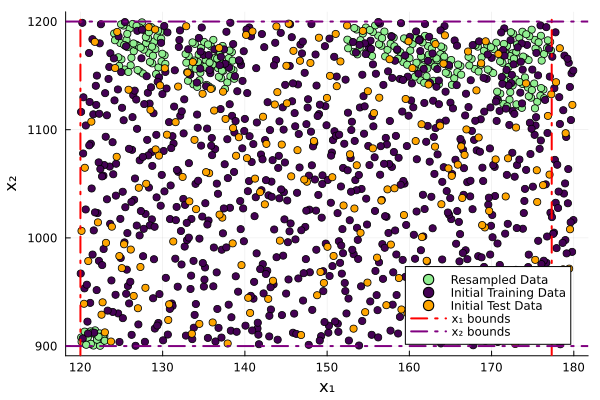

In [17]:
x_1st_added = hcat(data_temp_1st_new.x_train, data_temp_1st_new.x_test)
Plots.scatter(x_1st_added[1, :], x_1st_added[2, :], color = :lightgreen, xlabel="x₁", ylabel="x₂", legend=:bottomright, label="Resampled Data")
Plots.scatter!(data_temp.x_train[1, :], data_temp.x_train[2, :], color = :viridis, xlabel="x₁", ylabel="x₂", legend=:bottomright, label="Initial Training Data")
Plots.scatter!(data_temp.x_test[1, :], data_temp.x_test[2, :], color = :orange, legend=:bottomright, label="Initial Test Data")
vline!([sampling_config_1st.lb[1],sampling_config_1st.ub[1]], label="x₁ bounds", linestyle=:dashdot, color=:red, linewidth = 2)
hline!([sampling_config_1st.lb[2],sampling_config_1st.ub[2]], label="x₂ bounds", linestyle=:dashdot, color=:purple, linewidth = 2)

In [25]:
sampling_config_1st_filtered = Sampling_Config(
    sampling_config_1st.n_samples,
    sampling_config_1st.lb,
    sampling_config_1st.ub
)

config_temp_1st = NN_Config([6,50,50,1], [relu, relu, identity], false, 0.0, 0.0, Flux.Optimise.Optimiser(Adam(0.1, (0.9, 0.999)), ExpDecay(1.0)), 1, size(data_temp_1st_filtered.x_train)[2], 1000, 1)
train_time_1st = @elapsed result_temp_1st = NN_train(data_temp_1st_filtered, config_temp_1st, trained_model = model_init)
NN_results(config_temp_1st, result_temp_1st)

model_1st = result_temp_1st.model

Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Layers: [6, 50, 50, 1], Epochs: 1000, Lambda: 0.0, Dropout rate: 0.0
    Train Error[MSE, RRMSE, MAPE]: Float32[17.857468, 0.0001640316, 0.0037950003]
    Test Error [MSE, RRMSE, MAPE]: Float32[18.743935, 0.00032686625, 0.0039095366]


Chain(
  Dense(6 => 50),                       # 350 parameters
  NNlib.relu,
  Dropout(0.0, active=false),
  Dense(50 => 50),                      # 2_550 parameters
  NNlib.relu,
  Dense(50 => 1),                       # 51 parameters
  identity,
)                   # Total: 6 arrays, 2_951 parameters, 11.935 KiB.

In [26]:
BSON.@save joinpath(@__DIR__, "models/surrogate_1st.bson") model_1st
# BSON.@load joinpath(@__DIR__, "models/surrogate_1st.bson") model_1st

In [29]:
# convert the surrogate model to a MILP model
MILP_bt_1st = Model()
set_optimizer(MILP_bt_1st, Gurobi.Optimizer)
set_silent(MILP_bt_1st)
set_attribute(MILP_bt_1st, "TimeLimit", 10)

build_time = @elapsed _, _, _, _ = NN_formulate!(MILP_bt_1st, model_1st, sampling_config_1st_filtered.ub, sampling_config_1st_filtered.lb; 
    bound_tightening="fast", compress=true, silent=false)

@objective(MILP_bt_1st, Min, MILP_bt_1st[:x][2,1])
set_attribute(MILP_bt_1st, "TimeLimit", 1800)
solving_time = @elapsed optimize!(MILP_bt_1st)

Set parameter Username
Set parameter LicenseID to value 2603857
Academic license - for non-commercial use only - expires 2025-12-27
Starting compression...

LAYER 1
Removed 45/50 neurons

LAYER 2
Fully stable layer
Removed 50/50 neurons

LAYER 3
Creating JuMP model...

LAYER 1

LAYER 2


0.0038983

In [30]:
x_star_1st = [value.(MILP_bt_1st[:x][0,i]) for i in 1:length(MILP_bt_1st[:x][0,:])]
solution_evaluate(MILP_bt_1st, blade_max_temp, 1e-3)

        MIP solution: [120.0, 900.0, 40.0, 40.0, 30.0, 10.0]
     Objective value: 679.4286906596527
True objective value: 675.1318404785549


(679.4286906596527, 675.1318404785549, [120.0, 900.0, 40.0, 40.0, 30.0, 10.0], [120.0, 900.0, 40.0, 40.0, 30.0, 10.0], 0.006364460870416227)

In [31]:
# store multiple solutions in the solution pool
num_solutions_1st_filtered = MOI.get(MILP_bt_1st, MOI.ResultCount())
sol_pool_x_1st_filtered, _ = sol_pool(MILP_bt_1st, num_solutions_1st_filtered)

Solution 1:
   x = [120.0, 900.0, 40.0, 40.0, 30.0, 10.0]
 obj = 679.4286906596527
Solution 2:
   x = [120.0, 1110.341057298725, 20.0, 40.0, 30.0, 10.0]
 obj = 930.9137769843271


(Any[[120.0, 900.0, 40.0, 40.0, 30.0, 10.0], [120.0, 1110.341057298725, 20.0, 40.0, 30.0, 10.0]], Any[679.4286906596527, 930.9137769843271])

In [32]:
# apply Monte Carlo Dropout to the surrogate model
config_temp_1st_dp = NN_Config([6,50,50,1], [relu, relu, identity], false, 0.0, 0.1, Flux.Optimise.Optimiser(Adam(0.1, (0.9, 0.999)), ExpDecay(1.0)), 1, size(data_temp_1st_filtered.x_train)[2], 1000, 1)

train_time_1st_dp = @elapsed result_temp_1st_dp = NN_train(data_temp_1st_filtered, config_temp_1st_dp, trained_model = model_1st)

pred_1st, pred_dist_1st, means_1st, stds_1st, x_top_std_1st = predict_dist(data_temp_1st_filtered, result_temp_1st_dp.model, 100, 10)

Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000


(Matrix{Float32}[[760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384]  …  [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384], [760.64874 995.81366 … 689.0283 693.0384]], [[760.6487426757812; 760.6487426757812; … ; 760.6487426757812; 760.6487426757812;;], [995.8136596679688; 995.8136596679

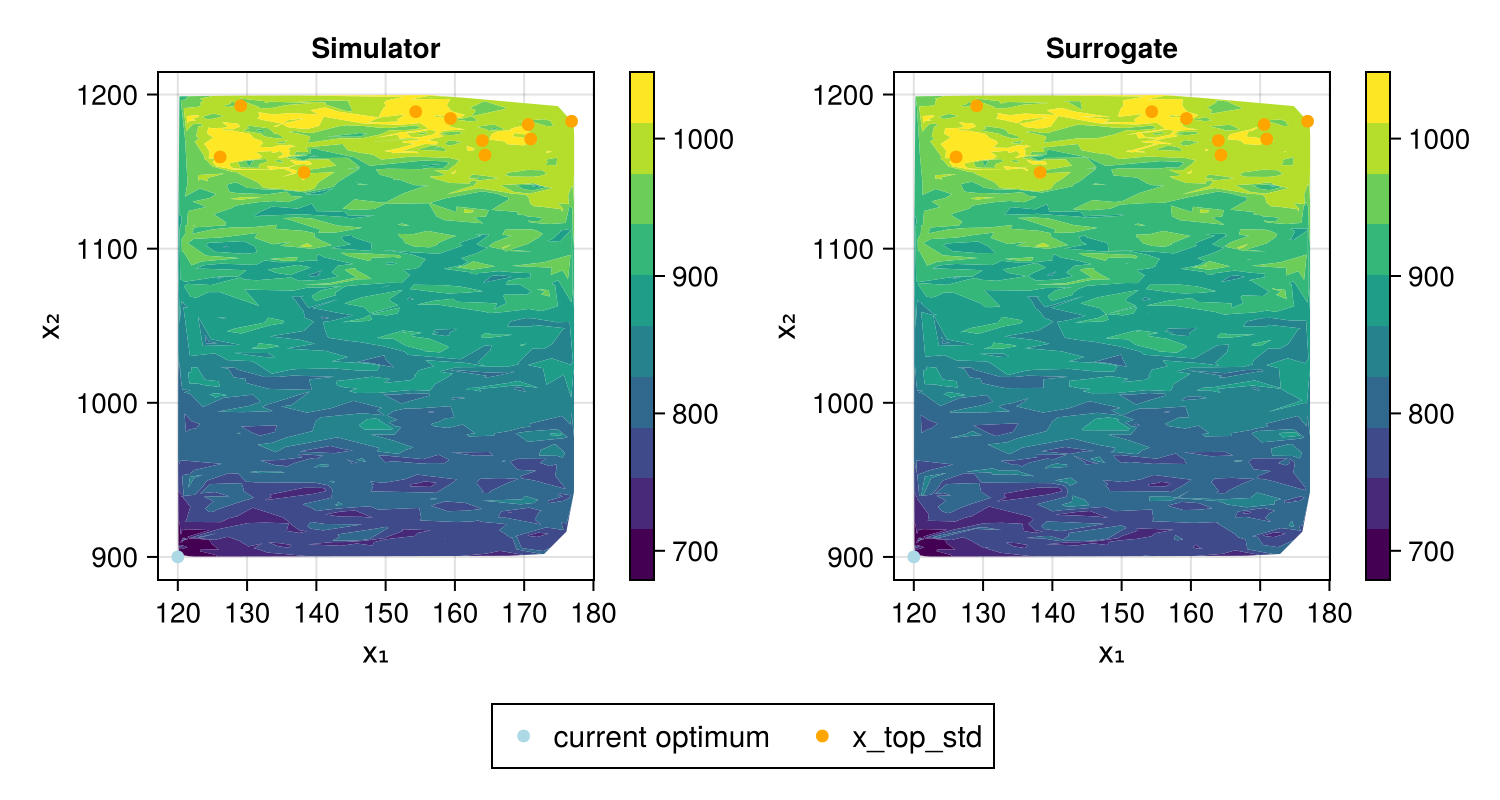

In [33]:
fig = plot_dual_contours(data_temp_1st_filtered, model_1st, x_star_1st, "x_top_std", [col for col in eachcol(x_top_std_1st)], [1,2], 1)

## 2nd iteration

In [34]:
# Resample densely around the points with the highest uncertainty
sampling_configs_2nd, sampling_config_2nd = generate_resample_configs_mc(sampling_config_1st_filtered, [x_top_std_1st x_star_1st hcat(sol_pool_x_1st_filtered...)[:, 2:end]], 0.10, 0.3, zeros(Float64, 6, 1), ones(Float64, 6, 1))

(Sampling_Config[Sampling_Config(8, [123.24312744140624, 1144.4622802734375, 20.0, 49.83796997070313, 45.9224853515625, 28.507503509521484], [128.97440185546876, 1174.4622802734375, 21.301876068115234, 51.28678588867187, 47.9224853515625, 30.0]), Sampling_Config(8, [135.37203369140624, 1134.4427490234375, 24.1859130859375, 52.95125122070313, 47.1138916015625, 28.179027557373047], [141.10330810546876, 1164.4427490234375, 26.1859130859375, 54.40006713867187, 49.1138916015625, 30.0]), Sampling_Config(8, [161.09560546875, 1155.1033935546875, 25.05987548828125, 43.03236694335938, 47.01885986328125, 22.08294677734375], [166.8268798828125, 1185.1033935546875, 27.05987548828125, 44.48118286132812, 49.01885986328125, 24.08294677734375]), Sampling_Config(8, [161.47060546875, 1145.7283935546875, 23.18487548828125, 43.40736694335938, 46.14385986328125, 21.45794677734375], [167.2018798828125, 1175.7283935546875, 25.18487548828125, 44.85618286132812, 48.14385986328125, 23.45794677734375]), Sampling_

In [35]:
data_temp_2nd_new = generate_and_combine_data(blade_max_temp, sampling_configs_2nd, SobolSample(), 0.8)
data_temp_2nd = combine_datasets(data_temp_1st_filtered, data_temp_2nd_new)
data_temp_2nd_filtered = filter_data_within_bounds(data_temp_2nd, sampling_config_2nd.lb, sampling_config_2nd.ub)

Data generated for config: #1
Data generated for config: #2
Data generated for config: #3
Data generated for config: #4
Data generated for config: #5
Data generated for config: #6
Data generated for config: #7
Data generated for config: #8
Data generated for config: #9
Data generated for config: #10
Data generated for config: #11
Data generated for config: #12


NN_Data(Float32[125.56641 161.74805 … 152.78549 120.134125; 948.33984 1156.2012 … 1077.2942 1006.469; … ; 38.61328 45.88867 … 38.341522 30.904999; 28.066406 28.291016 … 27.642365 10.479279], Float32[764.0843 997.7488 … 893.8673 808.66595], Float32[159.04037 157.34116 … 121.61192 120.1791; 933.81274 1044.8479 … 1108.4661 1123.4661; … ; 32.31125 42.33078 … 30.1875 30.6875; 19.385529 13.233185 … 10.6875 10.1875], Float32[758.58185 855.4147 … 925.35284 934.40424])

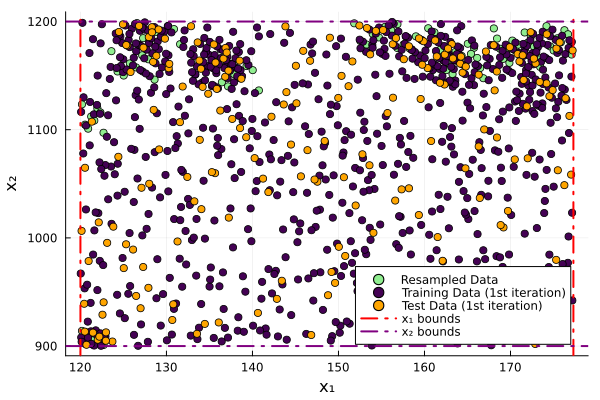

In [36]:
x_2nd_added = hcat(data_temp_2nd_new.x_train, data_temp_2nd_new.x_test)

Plots.scatter(x_2nd_added[1, :], x_2nd_added[2, :], color = :lightgreen, xlabel="x₁", ylabel="x₂", legend=:bottomright, label="Resampled Data")
Plots.scatter!(data_temp_1st_filtered.x_train[1, :], data_temp_1st_filtered.x_train[2, :], color = :viridis, xlabel="x₁", ylabel="x₂", legend=:bottomright, label="Training Data (1st iteration)")
Plots.scatter!(data_temp_1st_filtered.x_test[1, :], data_temp_1st_filtered.x_test[2, :], color = :orange, legend=:bottomright, label="Test Data (1st iteration)")
vline!([sampling_config_2nd.lb[1],sampling_config_2nd.ub[1]], label="x₁ bounds", linestyle=:dashdot, color=:red, linewidth = 2)
hline!([sampling_config_2nd.lb[2],sampling_config_2nd.ub[2]], label="x₂ bounds", linestyle=:dashdot, color=:purple, linewidth = 2)

In [37]:
sampling_config_2nd_filtered = Sampling_Config(
    sampling_config_2nd.n_samples,
    sampling_config_2nd.lb,
    sampling_config_2nd.ub
)

Sampling_Config(96, [120.0, 900.0, 20.0, 40.0, 30.0, 10.0], [177.312744140625, 1200.0, 40.0, 54.46522216796875, 50.0, 30.0])

In [43]:
config_temp_2nd = NN_Config([6,50,50,1], [relu, relu, identity], false, 0.0, 0.0, Flux.Optimise.Optimiser(Adam(0.1, (0.9, 0.999)), ExpDecay(1.0)), 1, size(data_temp_2nd_filtered.x_train)[2], 1000, 1)

train_time_2nd = @elapsed result_temp_2nd = NN_train(data_temp_2nd_filtered, config_temp_2nd, trained_model = model_1st)
NN_results(config_temp_2nd, result_temp_2nd)

model_2nd = result_temp_2nd.model

Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Layers: [6, 50, 50, 1], Epochs: 1000, Lambda: 0.0, Dropout rate: 0.0
    Train Error[MSE, RRMSE, MAPE]: Float32[12.755149, 0.00013095154, 0.0029681919]
    Test Error [MSE, RRMSE, MAPE]: Float32[14.692582, 0.0002800063, 0.0031382584]


Chain(
  Dense(6 => 50),                       # 350 parameters
  NNlib.relu,
  Dropout(0.0, active=false),
  Dense(50 => 50),                      # 2_550 parameters
  NNlib.relu,
  Dense(50 => 1),                       # 51 parameters
  identity,
)                   # Total: 6 arrays, 2_951 parameters, 11.935 KiB.

In [62]:
BSON.@save joinpath(@__DIR__, "models/surrogate_2nd.bson") model_2nd
# BSON.@load joinpath(@__DIR__, "models/surrogate_2nd.bson") model_2nd

In [45]:
# convert the surrogate model to a MILP model
MILP_bt_2nd = Model()
set_optimizer(MILP_bt_2nd, Gurobi.Optimizer)
set_silent(MILP_bt_2nd)
set_attribute(MILP_bt_2nd, "TimeLimit", 10)
build_time = @elapsed _, _, _, _ = NN_formulate!(MILP_bt_2nd, model_2nd, sampling_config_2nd_filtered.ub, sampling_config_2nd_filtered.lb; bound_tightening="fast", compress=true, silent=false)
@objective(MILP_bt_2nd, Min, MILP_bt_2nd[:x][2,1])
set_attribute(MILP_bt_2nd, "TimeLimit", 1800)
solving_time = @elapsed optimize!(MILP_bt_2nd)

Set parameter Username
Set parameter LicenseID to value 2603857
Academic license - for non-commercial use only - expires 2025-12-27
Starting compression...

LAYER 1
Removed 45/50 neurons

LAYER 2
Fully stable layer
Removed 50/50 neurons

LAYER 3
Creating JuMP model...

LAYER 1

LAYER 2


0.003428

In [46]:
x_star_2nd = [value.(MILP_bt_2nd[:x][0,i]) for i in 1:length(MILP_bt_2nd[:x][0,:])]
solution_evaluate(MILP_bt_2nd, blade_max_temp, 1e-3)

        MIP solution: [120.0, 900.0, 40.0, 40.0, 30.0, 10.0]
     Objective value: 675.9915796182071
True objective value: 675.1318404785549


(675.9915796182071, 675.1318404785549, [120.0, 900.0, 40.0, 40.0, 30.0, 10.0], [120.0, 900.0, 40.0, 40.0, 30.0, 10.0], 0.001273438887199883)

In [47]:
# store multiple solutions in the solution pool
num_solutions_2nd_filtered = MOI.get(MILP_bt_2nd, MOI.ResultCount())
sol_pool_x_2nd_filtered, _ = sol_pool(MILP_bt_2nd, num_solutions_2nd_filtered)

Solution 1:
   x = [120.0, 900.0, 40.0, 40.0, 30.0, 10.0]
 obj = 675.9915796182071
Solution 2:
   x = [120.0, 1110.341057298725, 20.0, 40.0, 30.0, 10.0]
 obj = 927.3484525546136


(Any[[120.0, 900.0, 40.0, 40.0, 30.0, 10.0], [120.0, 1110.341057298725, 20.0, 40.0, 30.0, 10.0]], Any[675.9915796182071, 927.3484525546136])

In [48]:
# apply Monte Carlo Dropout to the surrogate model
config_temp_2nd_dp = NN_Config([6,50,50,1], [relu, relu, identity], false, 0.0, 0.1, Flux.Optimise.Optimiser(Adam(0.1, (0.9, 0.999)), ExpDecay(1.0)), 1, size(data_temp_2nd_filtered.x_train)[2], 1000, 1)

train_time_2nd_dp = @elapsed result_temp_2nd_dp = NN_train(data_temp_2nd_filtered, config_temp_2nd_dp, trained_model = model_2nd)

pred_2nd, pred_dist_2nd, means_2nd, stds_2nd, x_top_std_2nd = predict_dist(data_temp_2nd_filtered, result_temp_2nd_dp.model, 100, 10)

Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000


(Matrix{Float32}[[760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487]  …  [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487], [760.2022 996.5902 … 927.3142 937.36487]], [[760.2022094726562; 760.2022094726562; … ; 760.2022094726562; 760.2022094726562;;], [996.5902099609375; 996.5902099609375; … ; 996.5902099

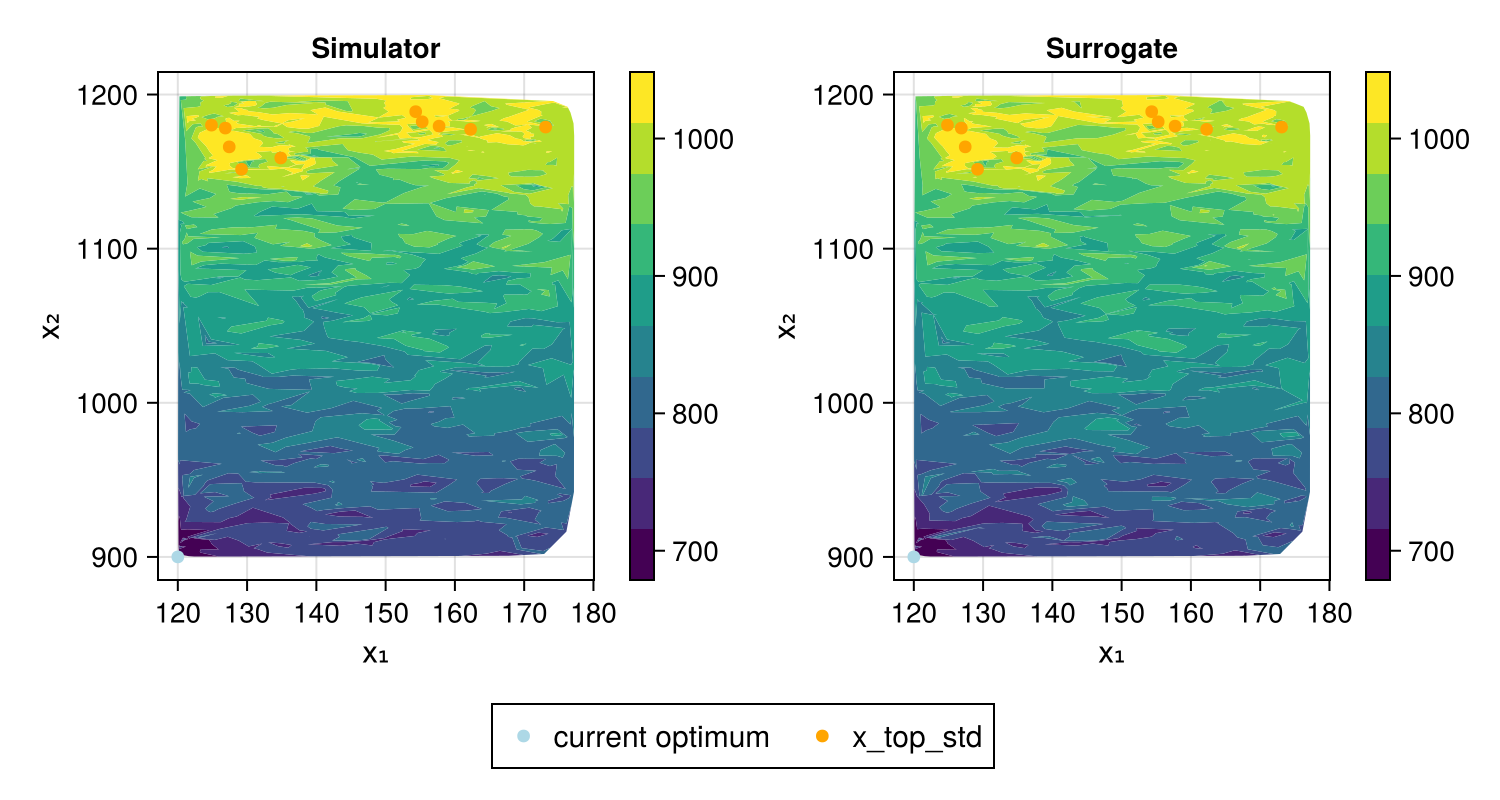

In [49]:
fig = plot_dual_contours(data_temp_2nd_filtered, model_2nd, x_star_2nd, "x_top_std", [col for col in eachcol(x_top_std_2nd)], [1,2], 1)

## 3rd iteration

In [50]:
sampling_configs_3rd, sampling_config_3rd = generate_resample_configs_mc(sampling_config_2nd_filtered, [x_top_std_2nd x_star_2nd], 0.10, 0.3, zeros(Float64, 6, 1), ones(Float64, 6, 1))

(Sampling_Config[Sampling_Config(3, [154.85079345703124, 1164.4903564453125, 20.411151885986328, 42.86328674316406, 40.8577880859375, 24.5833740234375], [160.58206787109376, 1194.4903564453125, 22.411151885986328, 44.30980895996094, 42.8577880859375, 26.5833740234375]), Sampling_Config(3, [124.55562744140624, 1151.0247802734375, 20.0, 50.40161682128906, 45.4849853515625, 28.9493408203125], [130.28690185546876, 1181.0247802734375, 21.9320068359375, 51.84813903808594, 47.4849853515625, 30.0]), Sampling_Config(3, [152.41329345703124, 1167.3028564453125, 20.0, 42.67578674316406, 41.6702880859375, 24.7708740234375], [158.14456787109376, 1197.3028564453125, 21.8062744140625, 44.12230895996094, 43.6702880859375, 26.7708740234375]), Sampling_Config(3, [123.99312744140624, 1163.2122802734375, 20.0, 49.58911682128906, 45.6724853515625, 28.901500701904297], [129.72440185546876, 1193.2122802734375, 21.543376922607422, 51.03563903808594, 47.6724853515625, 30.0]), Sampling_Config(3, [126.33687744140

In [51]:
data_temp_3rd_new = generate_and_combine_data(blade_max_temp, sampling_configs_3rd, SobolSample(), 0.8)
data_temp_3rd = combine_datasets(data_temp_2nd_filtered, data_temp_3rd_new)
data_temp_3rd_filtered = filter_data_within_bounds(data_temp_3rd, sampling_config_3rd.lb, sampling_config_3rd.ub)

Data generated for config: #1
Data generated for config: #2
Data generated for config: #3
Data generated for config: #4
Data generated for config: #5
Data generated for config: #6
Data generated for config: #7
Data generated for config: #8
Data generated for config: #9
Data generated for config: #10
Data generated for config: #11


NN_Data(Float32[125.56641 161.74805 … 161.53061 138.56186; 948.33984 1156.2012 … 1000.7561 1101.5374; … ; 38.61328 45.88867 … 48.707733 48.863983; 28.066406 28.291016 … 13.0867 25.11795], Float32[764.0843 997.7488 … 859.4794 986.2134], Float32[175.00717 134.4603 … 162.98494 121.79102; 966.1858 920.48267 … 1166.1571 901.875; … ; 45.69992 40.309296 … 43.001312 30.625; 19.063263 22.735138 … 13.702789 10.875], Float32[838.5294 775.69995 … 995.64026 680.941])

In [52]:
sampling_config_3rd_filtered = Sampling_Config(
    sampling_config_3rd.n_samples,
    sampling_config_3rd.lb,
    sampling_config_3rd.ub
)

Sampling_Config(33, [120.0, 900.0, 20.0, 40.0, 30.0, 10.0], [175.95963134765626, 1200.0, 40.0, 54.02392028808594, 50.0, 30.0])

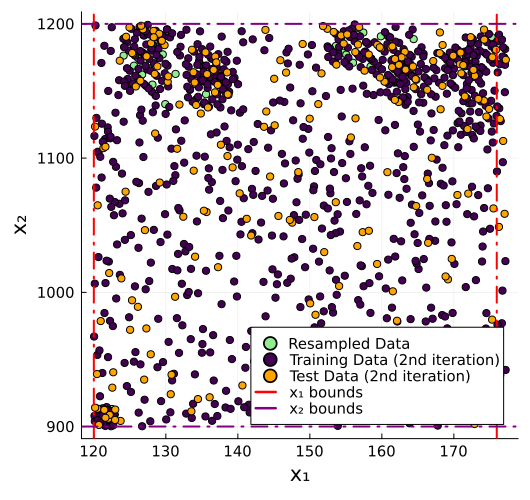

In [53]:
x_3rd_added = hcat(data_temp_3rd_new.x_train, data_temp_3rd_new.x_test)

Plots.scatter(x_3rd_added[1, :], x_3rd_added[2, :], color = :lightgreen, xlabel="x₁", ylabel="x₂", legend=:bottomright, label="Resampled Data", size = (530, 500), legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)
Plots.scatter!(data_temp_2nd_filtered.x_train[1, :], data_temp_2nd_filtered.x_train[2, :], color = :viridis, xlabel="x₁", ylabel="x₂", legend=:bottomright, label="Training Data (2nd iteration)", legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)
Plots.scatter!(data_temp_2nd_filtered.x_test[1, :], data_temp_2nd_filtered.x_test[2, :], color = :orange, legend=:bottomright, label="Test Data (2nd iteration)", legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)
vline!([sampling_config_3rd.lb[1],sampling_config_3rd.ub[1]], label="x₁ bounds", linestyle=:dashdot, color=:red, linewidth = 2, legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)
hline!([sampling_config_3rd.lb[2],sampling_config_3rd.ub[2]], label="x₂ bounds", linestyle=:dashdot, color=:purple, linewidth = 2, legendfontsize = 10, tickfontsize = 10, labelfontsize = 14)

In [54]:
config_temp_3rd = NN_Config([6,50,50,1], [relu, relu, identity], false, 0.0, 0.2, Flux.Optimise.Optimiser(Adam(0.1, (0.9, 0.999)), ExpDecay(0.1)), 1, size(data_temp_3rd_filtered.x_train)[2], 1000, 1)

train_time_3rd = @elapsed result_temp_3rd = NN_train(data_temp_3rd_filtered, config_temp_3rd, trained_model = model_2nd)
NN_results(config_temp_3rd, result_temp_3rd)

model_3rd = result_temp_3rd.model

Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Layers: [6, 50, 50, 1], Epochs: 1000, Lambda: 0.0, Dropout rate: 0.2
    Train Error[MSE, RRMSE, MAPE]: Float32[12.62492, 0.00013232238, 0.0029222323]
    Test Error [MSE, RRMSE, MAPE]: Float32[14.359197, 0.0002793857, 0.003023478]


Chain(
  Dense(6 => 50),                       # 350 parameters
  NNlib.relu,
  Dropout(0.0, active=false),
  Dense(50 => 50),                      # 2_550 parameters
  NNlib.relu,
  Dense(50 => 1),                       # 51 parameters
  identity,
)                   # Total: 6 arrays, 2_951 parameters, 11.935 KiB.

In [55]:
BSON.@save joinpath(@__DIR__, "models/surrogate_3rd.bson") model_3rd
# BSON.@load joinpath(@__DIR__, "models/surrogate_3rd.bson") model_3rd

In [56]:
# convert the surrogate model to a MILP model
MILP_bt_3rd = Model()
set_optimizer(MILP_bt_3rd, Gurobi.Optimizer)
set_silent(MILP_bt_3rd)
set_attribute(MILP_bt_3rd, "TimeLimit", 10)

build_time = @elapsed _, _, _, _ = NN_formulate!(MILP_bt_3rd, model_3rd, sampling_config_3rd_filtered.ub, sampling_config_3rd_filtered.lb; bound_tightening="fast", compress=true, silent=false)
@objective(MILP_bt_3rd, Min, MILP_bt_3rd[:x][2,1])

set_attribute(MILP_bt_3rd, "TimeLimit", 1800)
solving_time = @elapsed optimize!(MILP_bt_3rd)

Set parameter Username
Set parameter LicenseID to value 2603857
Academic license - for non-commercial use only - expires 2025-12-27
Starting compression...

LAYER 1
Removed 45/50 neurons

LAYER 2
Fully stable layer
Removed 50/50 neurons

LAYER 3
Creating JuMP model...

LAYER 1

LAYER 2


0.004082

In [57]:
x_star_3rd = [value.(MILP_bt_3rd[:x][0,i]) for i in 1:length(MILP_bt_3rd[:x][0,:])]
solution_evaluate(MILP_bt_3rd, blade_max_temp, 1e-3)

        MIP solution: [120.0, 900.0, 40.0, 40.0, 30.0, 10.0]
     Objective value: 675.3718722733223
True objective value: 675.1318404785549
Gap = 0.0003555332164415538 <= 0.001 - the solution is accurate within tolerance.


(675.3718722733223, 675.1318404785549, [120.0, 900.0, 40.0, 40.0, 30.0, 10.0], [120.0, 900.0, 40.0, 40.0, 30.0, 10.0], 0.0003555332164415538)

In [58]:
# store multiple solutions in the solution pool
num_solutions_3rd_filtered = MOI.get(MILP_bt_3rd, MOI.ResultCount())
sol_pool_x_3rd_filtered, _ = sol_pool(MILP_bt_3rd, num_solutions_3rd_filtered)

Solution 1:
   x = [120.0, 900.0, 40.0, 40.0, 30.0, 10.0]
 obj = 675.3718722733223
Solution 2:
   x = [120.0, 1110.341057298725, 20.0, 40.0, 30.0, 10.0]
 obj = 927.0757017194746


(Any[[120.0, 900.0, 40.0, 40.0, 30.0, 10.0], [120.0, 1110.341057298725, 20.0, 40.0, 30.0, 10.0]], Any[675.3718722733223, 927.0757017194746])

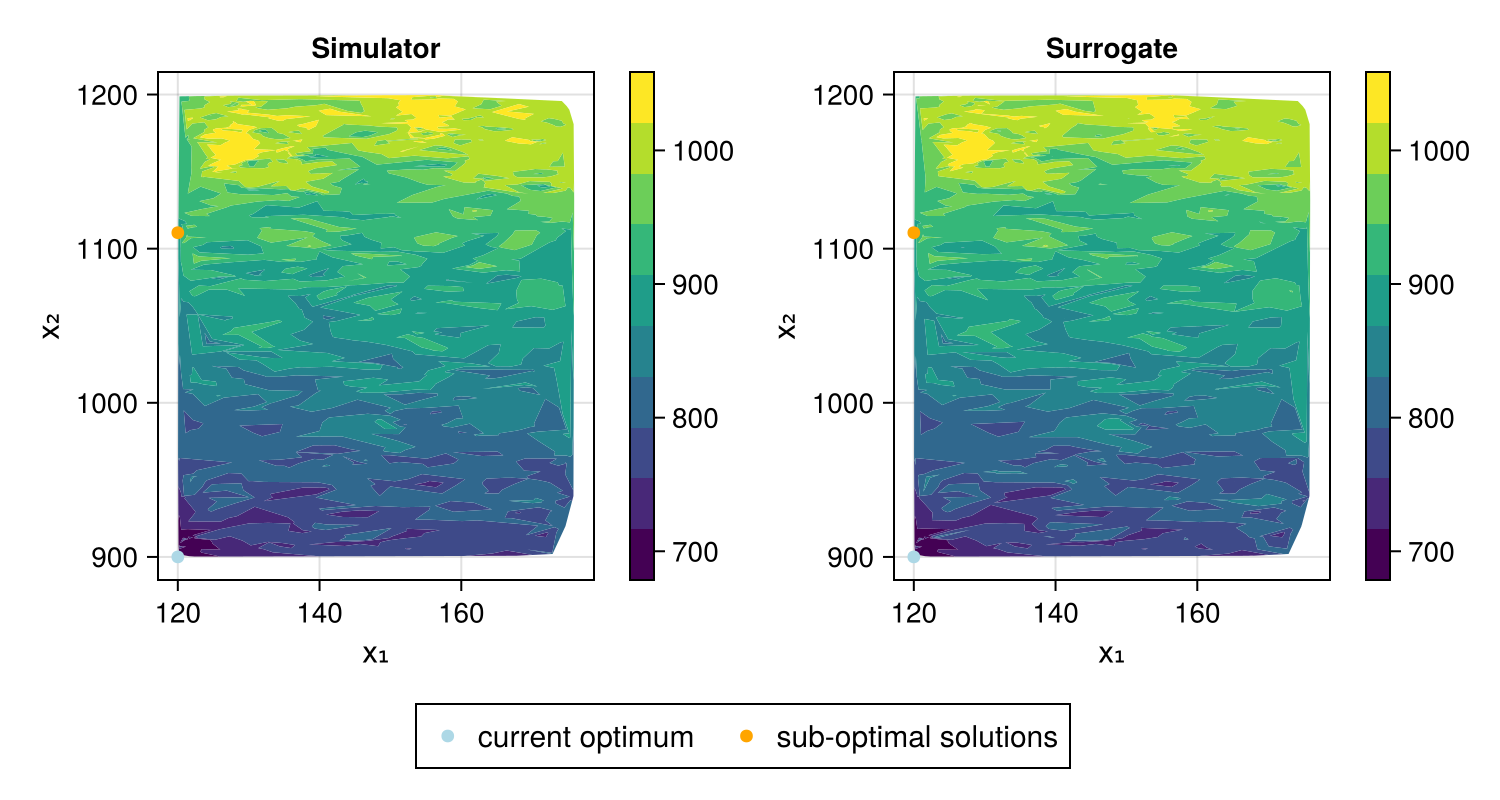

In [59]:
# visualise the surrogate model
fig = plot_dual_contours(data_temp_3rd_filtered, model_3rd, x_star_3rd, "sub-optimal solutions", sol_pool_x_3rd_filtered, [1,2], 1)